In [1]:
import pickle

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Overview

Let's create a **connected caveman graph** composed by `n` cliques representing our teams. The idea is to label each team based on their position in the graph.

In [2]:
# The connected caveman graph is formed by n cliques of size k, then a single edge in each clique is rewired to a node in an adjacent clique.
np.random.seed(123) 

k = 10 # size of each teams: number of members
n = 200 # number of teams

In [3]:
G = nx.connected_caveman_graph(n, k) 

In [4]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 2000
Number of edges: 9000


In [5]:
df = pd.DataFrame(G.nodes(), columns = ["node"])
df["team"] = pd.Series(range(0, n)).repeat(k).tolist()
df.head()

,node,team
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [6]:
# Get teams composition.
df = df.groupby("team", as_index = False).agg(members = ("node", list))
df.head()

,team,members
0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
1,1,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]"
2,2,"[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]"
3,3,"[30, 31, 32, 33, 34, 35, 36, 37, 38, 39]"
4,4,"[40, 41, 42, 43, 44, 45, 46, 47, 48, 49]"


In [7]:
# Define intervals in order to create positional labels for the teams. 
# N.B. It's a positional label because the teams are created one after the other in position by construction (see graph documentation).
intervals = np.array([0, n/3, 2*(n/3), n])
df["label"] = pd.cut(df["team"], intervals, right = False, labels = [0, 1, 2], include_lowest = True)
df.head()

,team,members,label
0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0
1,1,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]",0
2,2,"[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]",0
3,3,"[30, 31, 32, 33, 34, 35, 36, 37, 38, 39]",0
4,4,"[40, 41, 42, 43, 44, 45, 46, 47, 48, 49]",0


In [8]:
df["label"].value_counts()

label
0    67
1    67
2    66
Name: count, dtype: int64

In [9]:
# Create team composition dictionary: {node_id: [team_id]}.
teams_composition = df.explode("members").groupby("members").apply(lambda x: list(x["team"])).to_dict()
# Create team label dictionary: {team_id: label}.
teams_label = df.set_index("team")["label"].to_dict()

In [10]:
# Add team attribute to each node.
nx.set_node_attributes(G, teams_composition, "Team")  

In [11]:
# Save networkx graph.
with open(f"./data/graph.pkl", "wb") as f:
    pickle.dump(nx.readwrite.json_graph.node_link_data(G), f)
    
# Save teams label.
with open(f"./data/teams_label.pkl", "wb") as out:
    pickle.dump(teams_label, out)

# Visualization

Let's reproduce the previous graph in a smaller scale.

In [12]:
np.random.seed(123) 

k = 5 # size of each teams: number of members
n = 9 # number of teams

G = nx.connected_caveman_graph(n, k) 

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

df = pd.DataFrame(G.nodes(), columns = ["node"])
df["team"] = pd.Series(range(0, n)).repeat(k).tolist()
# Get teams composition.
df = df.groupby("team", as_index = False).agg(members = ("node", list))
# Get teams label.
intervals = np.array([0, n/3, 2*(n/3), n])
df["label"] = pd.cut(df["team"], intervals, labels = [0, 1, 2], right = False, include_lowest = True)
df = df.explode("members", ignore_index = True)
df.head()

Number of nodes: 45
Number of edges: 90


,team,members,label
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0


In [13]:
node_teams = df.set_index("members")["team"].to_dict()
node_labels = df.set_index("members")["label"].to_dict()
node_colors = [sns.color_palette("pastel")[label] for label in df["label"].tolist()]

In [14]:
# Add team attribute to each node.
nx.set_node_attributes(G, node_teams, "Team") 
nx.set_node_attributes(G, node_labels, "Label") 

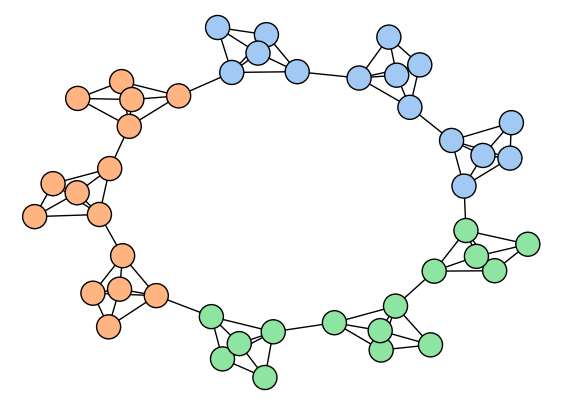

In [15]:
fig, ax = plt.subplots(figsize = (7, 5)) 
ax.axis("off")

nx.draw_kamada_kawai(G, node_color = node_colors, linewidths = 1., node_size = 300, connectionstyle = "arc3, rad = 0.1",
                     arrowsize = 5, ax = ax)
ax.collections[0].set_edgecolor("k") 

fig.savefig("./data/position.png", bbox_inches = "tight", dpi = 300)